# Automatsko prevođenje

Ovaj primer demonstrira korišćenje rekurentnih neuronskih mreža u zadatku automatskog prevođenja. Jezik sa kojeg se prevodi se često naziva izvorni jezik (engl. source language), a jezik na koji se prevodi ciljni jezik (engl. target language). Biće korišćen `sequence-to-sequence` pristup kojim se jedna rečenica izvornog jezika prevodi u rečenicu ciljnog jezika. Rečenice će se posmatrati kao sekvence karaktera, a kako ulazne i izlazne sekvence mogu biti proizvoljnih dužina reč je o `many-to-many` varijanti ove mreže. <img src='assets/many_to_many_v1.png' style='width: 500px'>

Prvo ćemo učitati potrebne biblioteke.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

## Ideja algoritma

Za učenje će se koristiti kompozicija mreža koja ima deo za kodiranje i deo za dekodiranje nalik slici. 
<img src='assets/encoder_decoder_words.png' style='width: 600px'>

<span style='color: gray'> Napomena: Na slikama će mahom biti prikazani sistemi prevođenja koji funkcionišu na nivou reči. Da bismo smanjili dimenzionalnost problema, mi ćemo raditi sa sistemom prevođenja na nivou karaktera. Opisani i prikazani principi su fundamentalno isti za obe varijante. </span>

Zadatak mreže za kodiranje ce biti da svakoj rečenici, niski karaktera izvornog jezika, pridruži odgovarajuću međureprezentaciju fiksne dužine. Zadatak mreže za dekodiranje će biti da na osnovu dobijene međureprezentacije generiše odgovarajuću rečenicu, nisku karaktera ciljnog jezika.

Mreža za kodiranje i mreža za dekodiranje će se trenirati zajednički (engl. end-to-end) tako da maksimizuju verovatnoću predviđanja tačne rečenice.  

Obe mreže će biti LSTM mreže zbog praćenja zavisnosti u ulazima. 

#### Koraci algoritma:

1) Počećemo sa sekvencom izvornog jezika i njoj odgovarajućom sekvencom izlaznog jezika. 

2) Deo za kodiranje će transformisati sekvencu izvornog jezika u vektor stanja i aktivacija koji će predstavljati međureprezentaciju rečenice. Izlazi mreže neće biti interesantni. 

3) Deo za dekodiranje će biti treniran tako da uči jezički model ciljnog jezika. Jezički model za dati ulazni karakter generiše vektor verovatnoća narednog karaktera. Ovaj model se uči tako što se mreži prosleđuje ulaz oblika $<start\ sequence>c_1c_2...c_k$ i zahteva izlaz oblika $c_1c_2...c_k<end\ sequence>$ (tzv. teacher forcing). Pocetno stanje ove mreže odgovara međureprezentaciji koju je generisao deo za kodiranje, a ulaz je token koji predstavlja početak sekvence. Treniranjem, dekoder uči da generiše $targets[t+1...]$ za dato $targets[...t]$ i početno stanje.
<img src='assets/seq2seq_training.png'>

## Priprema podataka

U primeru ćemo koristi englesko-francuski skup podataka koji sadrži rečenice na engleskom jeziku i njihove prevode na francuski jezik. Skup se može preuzeti sa [ove](http://www.manythings.org/anki/) adrese pod imenom `French - English fra-eng.zip (175623)`. 

In [4]:
# recenice izvornog jezika
input_texts = []

# skup karaktera izvornog jezika
input_characters = set()

# recenice ciljnog jezika
target_texts = []

# skup karaktera ciljnog jezika
target_characters = set()

Potom ćemo učitati rečenice preuzetog skupa podataka.

In [5]:
data_path = 'data/fra-eng/fra.txt'

In [6]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [7]:
number_of_sentence_pairs = len(lines)
print ('Broj raspolozivih recenica: ', number_of_sentence_pairs)

Broj raspolozivih recenica:  154884


Jedna linija ovako pročitanog fajla je oblika `rečenica_na_engleskom\t rečenica_na_francuskom`.

In [8]:
lines[120]

'Hang on!\tAttends un peu !'

Zbog računske zahtevnosti, za treniranje ćemo odabrati samo jedan deo rečenica npr. prvih 10000.

In [9]:
number_of_samples = 10000  

Sledećim fragmentom koda se vrši izdvajanje rečenica izvornog i ciljnog jezika, kao i kreiranje odgovarajućih skupova karaktera.

In [10]:
# za svaku recenicu izdvojenog podskupa
for line in lines[: min(number_of_samples, number_of_sentence_pairs - 1)]:
    
    # izdvajamo recenice izvornog i ciljnog jezika
    input_text, target_text = line.split('\t')
    
    # svakoj recenici ciljnog jezika pridruzicemo "tab" kao "start sequence" karakter 
    # i "new line" kao "end sequence" karakter
    target_text = '\t' + target_text + '\n'
   
    # dodajemo recenice u odgovarajuce skupove
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # svaki karakter izvornog jezika cemo dodati odgovarajucem skupu karaktera
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # svaki karakter ciljnog jezika cemo dodati odgovarajucem skupu karaktera
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

Odredićemo i dužinu najduže rečenice izvornog tj. ciljnog jezika.

In [11]:
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [12]:
print ('Maksimalna duzina ulazne recenice: ', max_encoder_seq_length)
print ('Maksimalna duzina ciljne recenice: ', max_decoder_seq_length)

Maksimalna duzina ulazne recenice:  16
Maksimalna duzina ciljne recenice:  59


Dalje, sortiraćemo alfabetski skupove karaktera.

In [13]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

In [14]:
print ('Karakeri izvornog jezika: ', input_characters)
print ('Karakteri ciljnog jezika: ', target_characters)

Karakeri izvornog jezika:  [' ', '!', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Karakteri ciljnog jezika:  ['\t', '\n', ' ', '!', '$', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '3', '5', '6', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '’', '\u202f']


Dalje ćemo odrediti broj različitih karaktera sa kojima radimo i u izvornom i ciljnom jeziku.

In [15]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

In [16]:
print ('Broj karaktera izvornog jezika: ', num_encoder_tokens)
print ('Broj karaktera ciljnog jezika: ', num_decoder_tokens)

Broj karaktera izvornog jezika:  71
Broj karaktera ciljnog jezika:  94


Formiraćemo rečnike koji preslikavaju karaktere u odgovarajuće numeričke vrednosti.

In [17]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

Na primer, slovo 'a' engleskog jezika se prislikava u kod 45, dok se slovo 'Ç' francuskog jezika preslikava u kod 75. 

In [18]:
print (input_token_index['a'])
print (target_token_index['Ç'])

45
75


## Kreiranje skupova za učenje

Za učenje su nam potrebna tri skupa: skup koji kodira rečenice izvornog jezika (encoder_input_data) koji je nephodan za obučavanje mreže za kodiranje, i dva skupa koja će biti korišćena od strane mreže za dekodiranje (decoder_input_data i decoder_target_data) kojim će se učiti jezički model ciljnog jezika. 

Ovi skupovi ce biti prikazani kao 3D tenzori: svakoj rečenici će biti pridružen niz brojeva koji odgovaraju pozicijama karaktera u skupu karaktera, a zatim će se pojedinačni karakteri kodirati odgovarajućim `one-hot` reprezentacijama. Prva dimenzija će predstavljati broj rečenica sa kojima se radi, druga maksimalni broj karaktera koji se može naći u rečenici, a treća broj karaktera kojim se raspolaže u jeziku. 

In [19]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

In [20]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    # odredjujemo one-hot reprezentaciju recenice izvornog jezika 
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    # odredjujemo one-hot reprezentacije recenice ciljnog jezika
    # recenice koja se prosledju kao ulaz i izlaz dekoderu su pomerene za jedan karakter 
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [21]:
encoder_input_data.shape

(10000, 16, 71)

In [22]:
decoder_input_data.shape

(10000, 59, 94)

In [23]:
decoder_target_data.shape

(10000, 59, 94)

## Mreža

Model mreže sa kojim ćemo raditi nije sekvencijalni. Sekvencijalni modeli pretpostavljaju da mreža ima tačno jedan ulaz i tačno jedan izlaz i da se između nalaze uvezani slojevi. Mreža koja će se koristi u automatskom prevođenju zajednički uči i koder i dekoder sa svojim ulazima. 

Praksa je da se u ovakvim slučajevima, kada mreža nije sekvencijalna, koristi funkcionalni API Keras biblioteke. 

### Mreža za kodiranje

In [24]:
# duzina medjureprezentacije recenice izvornog jezika 
# u literaturi se ovo zove i latentna dimenzija dela za kodiranje
latent_dim = 256  

# ulazni tenzor: 
encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_inputs')

# LSTM sloj: broj LSTM celija u sloju odgovara duzini medjureprezentacije recenice izvornog jezika 
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_outputs')

# na izlazu LSTM sloja ce se naci samo poslednji rezultat, poslednja vrednost aktivacije (skrivenog stanja) i poslednja vrednost stanja  
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# za dalji rad bice potrebne samo vrednosti aktivacija i stanje mreze - one ce sluziti kao kontekst za prevodjenje
encoder_states = [state_h, state_c]

### Mreža za dekodiranje

In [25]:
# ulazni tenzor
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')

# LSTM sloj: broj LSTM celija u sloju odgovara duzini medjureprezentacije recenice dela za kodiranje 
# ovaj sloj ce vratiti izlaz svih pojedinacnih ulaza, vrednosti njihovih aktivacija i stanja 
# vrednosti stanja necemo koristiti u procesu treniranja modela, ali cemo ih koristiti u delu vezanom za zakljucivanje
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_outputs')

# prilikom kreiranje sloja, za inicijalno stanje LSTM sloja se koristi medjureprezentacija dobijena od strane dela za kodiranje 
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# kako dekoder koristimo za predikciju verovatnoca pojedinacnih karaktera, dodajemo gusti sloj 
# koji ima onoliko celija koliko ima karaktera u ciljnom jeziku; kao aktivaciju koristimo softmax
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='softmax')

# izlazni tenzor
decoder_outputs = decoder_dense(decoder_outputs)

### Konačni model

In [26]:
# model ocekuje zadavanje ulaznih tenzora i izlazne transformacije
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [27]:
# model.summary(line_length=220)

Možemo prikazati i u formi grafa kako će model funkcionisati. 

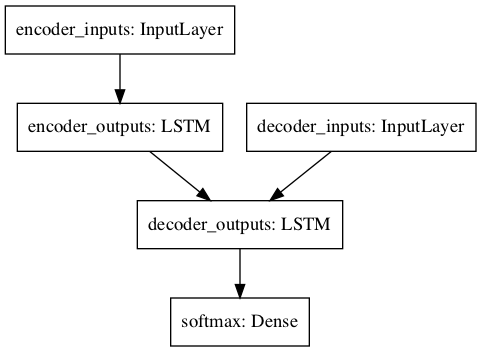

In [28]:
keras.utils.plot_model(model)

## Treniranje i evaluacija

Mreža će koristiti `RMSprop` optimizator i kategoričku unakrsnu entropiju kao funkciju gubitka. 

In [29]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

Mrežu ćemo trenirati paketićima veličine 64 u 20 epoha. Broj epoha je poželjno da bude duži, ali se ovde ograničavamo zbog vremenske zahevnosti. 20% skupa podataka ćemo iskoristiti za validaciju.

In [30]:
batch_size = 64
epochs = 20

Treniranje ove mreže traje nešto duže (oko pola sata).

In [31]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 1)

Epoch 1/20
125/125 [==============================] - 46s 366ms/step - loss: 0.9259 - acc: 0.0662 - val_loss: 1.0033 - val_acc: 0.0825
Epoch 2/20
125/125 [==============================] - 42s 338ms/step - loss: 0.7485 - acc: 0.1136 - val_loss: 0.8159 - val_acc: 0.1312
Epoch 3/20
125/125 [==============================] - 47s 375ms/step - loss: 0.6340 - acc: 0.1382 - val_loss: 0.7180 - val_acc: 0.1527
Epoch 4/20
125/125 [==============================] - 42s 337ms/step - loss: 0.5734 - acc: 0.1530 - val_loss: 0.6610 - val_acc: 0.1693
Epoch 5/20
125/125 [==============================] - 46s 364ms/step - loss: 0.5296 - acc: 0.1658 - val_loss: 0.6164 - val_acc: 0.1842
Epoch 6/20
125/125 [==============================] - 44s 355ms/step - loss: 0.4973 - acc: 0.1742 - val_loss: 0.5935 - val_acc: 0.1918
Epoch 7/20
125/125 [==============================] - 49s 389ms/step - loss: 0.4710 - acc: 0.1813 - val_loss: 0.5738 - val_acc: 0.1958
Epoch 8/20
125/125 [==============================] - 4

Uspešnost treniranja ćemo pratiti kroz grafike funkcija gubitka i tačnosti.

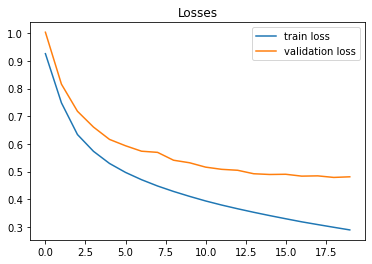

In [32]:
epochs_vals = range(0, epochs)
losses=history.history['loss']
val_losses=history.history['val_loss']
plt.title('Losses')
plt.plot(epochs_vals, losses, label='train loss')
plt.plot(epochs_vals, val_losses, label='validation loss')
plt.legend(loc='best')

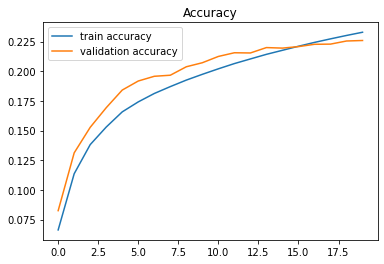

In [33]:
epochs_vals = range(0, epochs)
acc=history.history['acc']
val_acc=history.history['val_acc']
plt.title('Accuracy')
plt.plot(epochs_vals, acc, label='train accuracy')
plt.plot(epochs_vals, val_acc, label='validation accuracy')
plt.legend(loc='best')

Na ovaj način istrenirani model je sačuvan u folderu `models` pod imenom `s2s_2021.h5`. Može se učitati za dalje praćenje sadržaja. 

In [34]:
# model.save('models/s2s_2021.h5')
model = keras.models.load_model('models/s2s_2021.h5')

## Evaluacija modela

Da bi se evaluirao ovako dobijeni model, potrebno je za rečenice skupa za testiranje generisati odgovarajuće prevode. 
Koraci koje ćemo pratiti će biti sledeći:

1) ulazna rečenica se prvo prevede u odgovarajuću međureprezentaciju tako što se propusti kroz deo za kodiranje

2) na osnovu ovako dobijene reprezentacije i "start sequence" ulaza, puštaćemo da dekoder generiše rečenicu ciljnog jezika. Generisanje rečenice se zaustavlja ili kada se generiše "end sequence" karakter ili kada se dostigne maksimalna dozvoljena dužina. Proces generisanja se sastoji u praćenju pojedinačnih izlaza i njihovom prosleđivanju na ulazu sledećim iteracijama. 
<img src='assets/seq2seq_evaluation.png'>

Prvo ćemo kreirati deo za kodiranje.

In [36]:
# Model koji odgovara delu za kodiranje
# nacin zadavanja je u skladu sa funkcionalnim API-jem Keras biblioteke pa se ocekuju ulazni i izlazni tenzor 
encoder_model = Model(encoder_inputs, encoder_states)

encoder_model.summary(line_length=110)

Model: "functional_3"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
encoder_inputs (InputLayer)                      [(None, None, 71)]                          0                
______________________________________________________________________________________________________________
encoder_outputs (LSTM)                           [(None, 256), (None, 256), (None, 256)]     335872           
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
______________________________________________________________________________________________________________


Potom ćemo kreirati deo za dekodiranje.

In [37]:
# tenzori koji predstavljaju pocetno stanje dekodera
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# ulazni lstm sloj
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# izlazni sloj
decoder_outputs = decoder_dense(decoder_outputs)

# spajanje svih delova u model 
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

decoder_model.summary(line_length=110)

Model: "functional_5"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
decoder_inputs (InputLayer)         [(None, None, 94)]      0                                                 
______________________________________________________________________________________________________________
input_1 (InputLayer)                [(None, 256)]           0                                                 
______________________________________________________________________________________________________________
input_2 (InputLayer)                [(None, 256)]           0                                                 
______________________________________________________________________________________________________________
decoder_outputs (LSTM)              [(None, None, 256), (No 359424       decoder_inputs[0]

Zbog praćenja rezultata rada dekodera, biće nam potrebne i funkcije koje vraćaju vrednosti karaktera za zadate numeričke vrednosti koje odgovaraju pozicijama karaktera. 

In [38]:
reverse_input_char_index = dict( (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict( (i, char) for char, i in target_token_index.items())

In [39]:
print(reverse_input_char_index[45])
print(reverse_target_char_index[75])

a
Ç


Funkcija `decode_sequence` objedinjuje sve korake dekodiranja generisane sekvence. Zbog jednostavnosti implementacije, pretpostavka je da je veličina paketića za testiranje 1 (batch_size=1) tj. da se obrađuje jedna ulazna sekvenca i generiše jedna izlazna sekvenca. 

In [40]:
def decode_sequence(input_seq):

    # ulazna sekvenca se propusta kroz deo za kodiranje
    states_value = encoder_model.predict(input_seq)

    # generise se vektor koji odgovara "start sequence" karakteru koji je u nasem slucaju tabulator
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    # postavlja se indikator kojim se proverava da li je generisana izlazna recenica ili ne
    stop_condition = False
    
    # izlazna recenica
    decoded_sentence = ''
    
    
    # sve dok se ne stigne do kraja recenice
    while not stop_condition:
        
        # prati se izlaz mreze za dekodiranje: prosledjuje joj se ulazni karakter i trenutno stanje mreze
        # u prvoj iteraciji trenutno stanje mreze odgovara izlazu dela za kodiranje
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # na osnovu izlazne raspodele verovatnoca, odredjuje se karakter sa najvecom verovatnocom
        # ovo je takozvana pohlepna tehnika (engl. greedy search) generisanja sekvence 
        # postoje i druge tehnike kojima se maksimizuje verovatnoca generisane sekvence poput bim pretrage (engl. beam search) 
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        # izdvojeni karakter se nadovezuje na izlaznu recenicu
        decoded_sentence += sampled_char

        
        # proverava se da li se stiglo do kraja recenice 
        # tj. da li se doslo do "end sequence" karaktera (znaka za novi red) ili maksimalne duzine izlaza
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

            
        # pripreme za nerednu iteraciju:
        
        # odredjuje se naredni ulazni karakter - izlaz prethodne iteracije 
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # azuriraju se stanja mreze 
        states_value = [h, c]

    return decoded_sentence

Sada ćemo na jednom skupu od 30tak rečenica testirati kako radi naučeni model. Koristićemo rečenice iz skupa za treniranje da bismo izbegli korake pripreme rečenica. U opštem slučaju bi bilo korektno koristiti rečenice nad kojima model nije obučavan.

In [41]:
for seq_index in range(10, 40):
    
    # izdvajamo ulaznu recenicu iz skupa koji je koriscen za treniranje 
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    # zatim pratimo njen prevod
    decoded_sentence = decode_sequence(input_seq)
    
    # i ispisujemo dobijene rezultate
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Humman translated sentence:', target_texts[seq_index])

-
Input sentence: Wait!
Decoded sentence: Attendez !

Humman translated sentence: 	Attendez !

-
Input sentence: Go on.
Decoded sentence: Va chez moi.

Humman translated sentence: 	Poursuis.

-
Input sentence: Go on.
Decoded sentence: Va chez moi.

Humman translated sentence: 	Continuez.

-
Input sentence: Go on.
Decoded sentence: Va chez moi.

Humman translated sentence: 	Poursuivez.

-
Input sentence: I see.
Decoded sentence: Je me suis senti mort.

Humman translated sentence: 	Je comprends.

-
Input sentence: I try.
Decoded sentence: Je l'ai pas laissé.

Humman translated sentence: 	J'essaye.

-
Input sentence: I won!
Decoded sentence: Je vous ai sauvée.

Humman translated sentence: 	J'ai gagné !

-
Input sentence: I won!
Decoded sentence: Je vous ai sauvée.

Humman translated sentence: 	Je l'ai emporté !

-
Input sentence: Oh no!
Decoded sentence: Fais comme chatte !

Humman translated sentence: 	Oh non !

-
Input sentence: Attack!
Decoded sentence: Attende !

Humman translated sen

Formalno, za evaluaciju sistema za prevođenje se koristi `BLUE` (aktronim od *bilingual evaluation understudy*) mera. Svakoj od prevedenih rečenica se pridružuje skor sa vrednošću iz intervala [0, 1], a zatim se dobijene vrednosti uproseče da bi se dobila konačna ocena sistema. Na nivou pojedinačnih rečenica skorovi se izračunavaju tako što se prati broj preklapanja n-grama u rečenici prevedenoj od strane sistema i rečenici prevedenoj od strane profesionalnih prevodilaca. Ovako dobijeni skorovi se mogu otežati faktorima koji prate dužinu rečenica. 

<img src='assets/blue.png'>

## Zadaci za vežbu:

* Napraviti zaseban test skup na osnovu rečenica koje nisu iskorišćene i testirati model.
* Eksperimentisati sa modelima koji koriste GRU ćelije. 

## Za istarživanje:

* Referentni rad [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)  
* Rad koji je prethodio ovoj ideji [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078) 
* [Razne primene generativnog karakterskog modela](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)